In [1]:
from ant_array2 import RadioArray
from allsky_viewer import AllSkyViewer, generate_skycat
from astropy.time import Time
import ephem
import numpy as np
import pylab as plt
import h5py
import hickle as hkl
from astropy.coordinates import SkyCoord
from coord_utils import skycoord_to_ephem
import hdf5plugin

In [2]:
img_cube_path    = 'eda-channel-sweep-image-cube.h5'
h5_metadata_path = 'imaging_metadata_2022.11.14.hkl'
antxyz_h5        = 'eda_antenna_locations_v2.h5'

h  = h5py.File(img_cube_path, 'r')
md = hkl.load(h5_metadata_path)

lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500

ts = Time(md['time'], format='jd')
f_mhz = md['freqs'] / 1e6

sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, antxyz_h5, t0=ts[0].datetime, verbose=False, 
                 phase_center=sun, conjugate_data=True)


asv = AllSkyViewer(observer=eda, ts=ts[0], f_mhz=f_mhz[0], n_pix=128)
skycat = generate_skycat(asv.observer)
asv.load_skycat(skycat)

In [3]:
%matplotlib widget
idx = 1000
img = h['data'][idx, ..., 1]
asv.new_fig(6)
asv.update(ts=ts[idx], f_mhz=f_mhz[idx])
asv.plot(img, overlay_srcs=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Grab out sources

In [63]:
import peak_find

In [89]:
peaks = peak_find.persistence(img)

In [93]:
peaklist = []
for ii in range(len(f_mhz)):
    img = h['data'][ii, :, :, 0]
    peaks = peak_find.persistence(img)
    peaklist.append(peaks[:10])
    if ii % 100 == 0: print(ii)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100


In [81]:
idxarr = []
for p in peaks:
    idxarr.append(p[0])
idxarr = np.array(idxarr)

In [100]:
hkl.dump(peaklist, "2022.11.16-prominent-peaks.hkl")

KeyboardInterrupt: 

In [5]:
peaklist = hkl.load("2022.11.16-prominent-peaks.hkl")

KeyboardInterrupt: 

In [45]:


def parse_peaks(peaks, N=10):
    idxs = np.zeros((10, 2), dtype='int32')
    vs = np.zeros((10), dtype='float32')
    for ii, p in enumerate(peaks):
        idxs[ii] = p[0]
        vs[ii]   = p[1]
    return idxs, vs

def parse_peaklist(peaklist):
    peaks = np.zeros(shape=(11200, 10, 2), dtype='int32')
    maxvals = np.zeros(shape=(11200, 10), dtype='float32')
    for ii, pks in enumerate(peaklist):
        idxs, vs = parse_peaks(pks)
        peaks[ii]   = idxs
        maxvals[ii] = vs
    return peaks, maxvals

def overlap(x, flip=True):
    N_fine    = 32
    N_overlap = 5
    N_coarse  = 350
    N_sel = N_fine - N_overlap*2 +1
    ch0 = x[N_overlap:N_fine-N_overlap]
    chs = []
    
    for ii in range(1, N_coarse):
        ch = x[ii*N_fine:(ii+1)*N_fine]
        if flip:
            chs.append(ch[N_overlap-1:-N_overlap][::-1])
        else:
            chs.append(ch[N_overlap-1:-N_overlap])
    return np.concatenate(chs)

In [34]:
from astropy.io import fits
a = fits.open('corr-data/chan_100_20200520T03433600.uvfits')

In [36]:
a[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    6 / number of data axes                            
NAXIS1  =                    0 / length of data axis 1                          
NAXIS2  =                    3 / length of data axis 2                          
NAXIS3  =                    4 / length of data axis 3                          
NAXIS4  =                   32 / length of data axis 4                          
NAXIS5  =                    1 / length of data axis 5                          
NAXIS6  =                    1 / length of data axis 6                          
EXTEND  =                    T / FITS dataset may contain extensions            
GROUPS  =                    T / random group records are present               
PCOUNT  =                    5 / number of random group parameters              
GCOUNT  =                328

In [108]:
peaks, maxvals = parse_peaklist(peaklist)

In [48]:
beams = hkl.load("beams-2022.11.14.hkl")
f_mhz  = beams['f_mhz']
_f, b_sun  = apply_rfi_mask(overlap(f_mhz), overlap(beams['Sun']))
_f, b_moon = apply_rfi_mask(overlap(f_mhz), overlap(beams['Moon']))
_f, b_pic  = apply_rfi_mask(overlap(f_mhz), overlap(beams['Pictor_A']))
_f, b_fnx  = apply_rfi_mask(overlap(f_mhz), overlap(beams['Fornax_A']))
f_mhz = overlap(f_mhz, flip=True)

In [49]:
%matplotlib widget
plt.plot(f_mhz, b_sun)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [242]:
sun_idx = [110, 56]
fornax_idx = [52, 63]
hydra_idx = [27, 19]
pictor_idx = [40, 40]

labeldict = {}

for l in set(labels):
    lp = pidxs[labels == l]
    if sun_idx in lp:
        labeldict['Sun'] = l
    if fornax_idx in lp:
        labeldict['Fornax_A'] = l
    if pictor_idx in lp:
        labeldict['Pictor_A'] = l
    if hydra_idx in lp:
        labeldict['Hydra_A'] = l

In [241]:
pidxs = peaks.reshape((11200*10, 2))
clustering = DBSCAN(eps=2.5, min_samples=2).fit(pidxs)
labels = clustering.labels_
n_clusters_ = set(labels)

In [14]:
import bottleneck as bn

def find_closest(x, x0):
    return np.argmin(np.abs(x-x0))

def apply_rfi_mask(f, d):
    #d = b_sun/b_pic
    tmask = overlap(md['time'] > md['time'][0] - 2)
    
    m = bn.move_median(d, 64)
    d = np.ma.array(d)
    d.mask = d < 0
    d.mask = np.logical_or(d.mask, ~tmask)
    #d.mask = np.logical_or(d.mask, ~tmask)

    masks = [
        [88, 108],
        [243, 270],
        [243, 244.3],
        [244.7, 245],
        [246.1, 246.5],
        [248, 271],
        [103, 108.5],
        [100.2, 100.4],
        [146, 147],
        [137, 137.2],
        [346, 346.3],
        [346.7, 348],
        [349.6, 350.2],
        [343, 350],
        ]

    for m in masks:
        i0 = find_closest(m[0], f)
        i1 = find_closest(m[1], f)
        d.mask[i0:i1] = True
        
    return f, d


In [216]:
img = h['data'][0, :, :, 0]

In [225]:
idxarr[4, 0], idxarr[4, 1],

(40, 40)

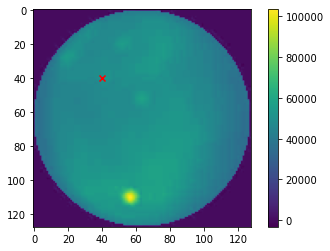

In [261]:
%matplotlib inline
plt.imshow(img)
plt.colorbar()
plt.scatter(idxarr[4, 1], idxarr[4, 0], marker='x', color='red')

In [180]:
asv.plot(img,overlay_srcs=True)
plt.scatter(idxarr[:5, 1], idxarr[:5, 0], marker='x', color='red')

NameError: name 'idxarr' is not defined

In [194]:
p = h['data'][0, 64, 64, :]
p = np.matrix([[p[0], p[3]], [p[2], p[1]]])

print("B_meas:")
display(np.round(p, 2))

print("J:")
J = compute_J(p)
display(np.round(J, 2))

B_meas:


array([[50176.,  1600.],
       [  216., 43008.]], dtype=float32)

J:


array([[223.98,   5.31],
       [ -1.1 , 207.36]])

In [191]:
from numpy.linalg import svd

def compute_J(p):
    u, d, uh = svd(p, hermitian=False)
    Dsqrt = np.matrix(np.array(((np.sqrt(d[0]), 0), (0, np.sqrt(d[1])))))
    J = np.matmul(np.matmul(u, Dsqrt), uh)
    return J

def dejones(J, p):
    return np.matmul(np.matmul(J.I, p), np.conj(J.I))

array([[219.21,   8.56],
       [  8.56, 199.66]])

array([[1.  , 0.03],
       [0.  , 1.  ]])

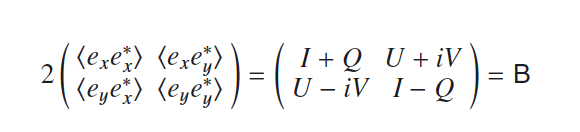

In [176]:
J

matrix([[219.2140271 ,   8.55633495],
        [  8.55633495, 199.65669054]])

In [195]:
A_over_T_low = 679.4

In [198]:
from astropy.constants import k_B
import astropy.units as u

In [240]:
A_over_T_low = 679.4
SEFD_low = 2 * k_B / A_over_T_low * (u.K / (u.m**2))
SEFD_low = SEFD_low.to('Jy')

A_over_T_mid = 1168   # at 8 GHz
SEFD_mid = 2 * k_B / A_over_T_mid * (u.K / (u.m**2))
SEFD_mid = SEFD_mid.to('Jy')

In [241]:
display(SEFD_low)
display(SEFD_mid)

<Quantity 4.06431852 Jy>

<Quantity 2.364125 Jy>

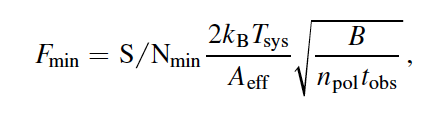

In [216]:
k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

<Quantity 0.01963189 W>

In [276]:
cbw  = 10 * u.kHz
npol = 1
tobs = 120 * u.s # 1 hr 
D = 250e6 * u.km
L = (SEFD_mid * np.sqrt( npol / tobs * cbw)) * 4 * np.pi * D**2 * 5
L.to('W')

<Quantity 0.84749998 W>

In [237]:
1923091.7289 / 1e6

1.9230917289